# Machine Learning para previsão de falhas e manutenção de equipamentos (PM)

Neste notebook, abordo detalhadamente um problema de manutenção preditiva. Esses tipos de problemas podem ser complicados por vários motivos. As primeiras seis seções tratam da construção de um modelo. As últimas seções tratam da avaliação da eficácia do modelo e da garantia de sua eficácia quando implantado na produção.


Quando se trata de lidar com máquinas que requerem manutenção periódica, geralmente há três resultados possíveis.

1. **você pode manter uma máquina com muita frequência**. Em outras palavras, a máquina recebe manutenção quando não é necessária. Nesse cenário, você está jogando dinheiro pela janela, desperdiçando recursos e fornecendo manutenção desnecessária. Por exemplo, você pode trocar o óleo do seu carro todos os dias. Isso não é o ideal e você desperdiçará muito dinheiro em manutenção desnecessária.

2. **você não mantém sua máquina com frequência suficiente**. A falta de manutenção de uma máquina significa que a máquina irá quebrar durante a operação. Aqui, os custos podem ser substanciais. Você não apenas tem os custos de reparo, mas também os custos associados à perda de produção. Se uma máquina na linha de montagem falhar, a linha não pode produzir nada. Nenhuma produção significa lucro perdido. Além disso, você incorrerá em custos legais e médicos se ocorrerem lesões como resultado da falha.

3. **uma máquina é mantida quando precisa de manutenção**. Esta é obviamente a melhor alternativa das três. Observe que ainda há um custo associado à manutenção oportuna.

Então, precisamos manter as máquinas quando elas precisam de manutenção, certo? Infelizmente, isso é mais fácil dizer do que fazer. Felizmente, podemos usar a manutenção preditiva (PM) para prever quando as máquinas precisam de manutenção.

Também devo mencionar que a maioria das máquinas vem com recomendações do fabricante sobre manutenção. O problema com as recomendações do fabricante é que elas representam uma média. Por exemplo, os carros, em média, precisam de uma troca de óleo a cada 3.000 milhas, mas com que frequência seu carro precisa de uma troca de óleo? Pode ser mais ou menos de 3.000 milhas, dependendo de vários fatores, incluindo onde você dirige, como dirige e com que frequência dirige.

A manutenção preditiva (PM) pode informar, com base em dados, quando uma máquina precisa de manutenção. Um programa de PM eficaz minimizará a manutenção insuficiente e excessiva de sua máquina. Para um grande fabricante com milhares de máquinas, ser preciso na manutenção das máquinas pode economizar milhões de dólares todos os anos.

Neste projeto, examinarei um caso de uso típico de manutenção preditiva (PM). À medida que passo por este exemplo, descreverei alguns dos problemas que surgem com os problemas de PM e sugerirei maneiras de resolvê-los.

Uma observação importante sobre os dados usados ​​neste exercício. É inteiramente falso. Criei os dados com base na minha experiência de lidar com esses tipos de problemas. Embora seja totalmente artificial, acredito que os dados e o caso de uso sejam muito realistas e consistentes com muitos problemas reais de PM.






A empresa em nosso caso de uso forneceu uma amostra de dados que inclui 421 máquinas que falharam em dois anos. Eles gastaram 11,766 milhões de dólares em manutenção, a maioria dos quais veio de máquinas em funcionamento até a falha.

Aqui está um resumo das máquinas mantidas ou reparadas nos últimos dois anos.

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")

A partir dos dados acima, atualmente custa à empresa cerca de US$ 28.000 por máquina com falha ou manutenção. Nosso objetivo é reduzir esse custo.

No gráfico acima, a Manutenção Oportuna custa mais do que a Manutenção Desnecessária. Há uma boa razão para isso. Para esta máquina, manutenção desnecessária significa que a máquina foi retirada de linha e verificada, mas a peça em questão apresentou desgaste insuficiente para substituição. Como as peças não foram substituídas, não há custos de material, apenas mão de obra.

Observe que esta empresa faz muito pouca manutenção preditiva. Na maioria das vezes, eles apenas executam as máquinas até a falha. Além disso, observe que essas máquinas quebrarão em quatro a oito anos se não receberem manutenção. Quando eles falham, eles devem ser retirados de linha e reparados.

Nosso objetivo é mostrar à empresa como um programa de Manutenção Preditiva pode economizar dinheiro. Para fazer isso, construiremos um modelo preditivo que prevê a falha da máquina em até 90 dias após a falha real. Observe que uma janela de falha apropriada sempre dependerá do contexto do problema. Se uma máquina quebrar sem manutenção em 6 meses, uma janela de três meses não faz sentido. Aqui, onde uma máquina funcionará entre 4 a 6 anos sem manutenção, uma janela de 90 dias é razoável.

Nosso objetivo é desenvolver uma solução que reduza os custos de falha. Novamente, atualmente custa à empresa cerca de 28.000 por máquina. Tentaremos reduzir este custo.

## Índice

1. [Configurando](#setup1)<br>
 
2. [Exploração de dados](#explore)<br>

3. [Transformação de dados e Feature Engineering](#trans)<br>
 
4. [Lidando com o pequeno número de falhas](#small)<br>
    4.1 [Expanda a janela de falha](#window)<br>
    4.2 [Criar Grupos de Teste, Treinamento e Validação](#groups)<br>
    4.3 [SMOTE os dados de treinamento](#smote)<br>
5. [Mais transformações de dados e Feature Engineering](#more)<br>
6. [Construir o modelo no conjunto de dados balanceado](#build)<br>
7. [Avalie o modelo](#score)<br>
    7.1 [Avaliar o modelo usando uma AUC e métricas de precisão](#7.1)<br>
    7.2 [Avaliando com uma Matriz de Confusão](#7.2)<br>
    7.3 [Usando Heurística para Definir um Falso Positivo, Verdadeiro Positivo, Falso Negativo e Verdadeiro Negativo](#7.3)<br>
    7.31 [Eliminar sinais de falha redundantes](#7.31)<br>
    7.32 [Identifique o ID da máquina para cada sinal. Identifique a data do sinal de falha.](#7.32)<br>
    7.33 [Criar uma matriz de confusão realista](#7.33)<br>
    7.34 [Incorporando a Economia do Problema.](#7.34)<br>
    7.4 [Ajustando a solução.](#7.4)<br>
11. [Conclusões](#conc)<br>

### 1.0 Configurando ambiente <a id="setup1"></a>

In [8]:
!pip uninstall imbalanced-learn -y

Found existing installation: imbalanced-learn 0.9.0
Uninstalling imbalanced-learn-0.9.0:
  Successfully uninstalled imbalanced-learn-0.9.0


In [9]:
#!pip install plotly 
#!pip install chart-studio 
#!pip install -U scikit-learn 

!pip install imbalanced-learn




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)


In [10]:
#import chart_studio.plotly as py
#import plotly.graph_objs as go
#import plotly as plotly
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import types
import pandas as pd

def __iter__(self): return 0




## Carregando dados

In [11]:
# Convert csv to pandas dataframe
pd_data_1 = pd.read_csv("/content/drive/MyDrive/Equipment_Maintenance/equipment_failure_data_1.csv", sep=",", header=0)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# convert to pandas dataframe
pd_data_2 = pd.read_csv("/content/drive/MyDrive/Equipment_Maintenance/equipment_failure_data_2.csv", sep=",", header=0)

In [14]:
#concatenate the two data files into one dataframe
pd_data=pd.concat([pd_data_1, pd_data_2])



### 2.0 Data Exporation <a id="explore"></a>

In [15]:
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


Agora que temos os dados importados para um Jupiter Notebook, podemos explorá-lo. Aqui estão os metadados explicando todos os campos no conjunto de dados.

ID — Campo de ID que representa uma máquina específica.

DATA — A data da observação.

REGION_CLUSTER — um campo que representa a região na qual a máquina reside.

MAINTENANCE_VENDOR — um campo que representa a empresa que fornece manutenção e serviço para a máquina.

FABRICANTE — a empresa que fabricou o equipamento em questão.

WELL_GROUP — um campo que representa o tipo de máquina.

EQUIPMENT_AGE — Idade da máquina, em dias.

S15 — Um valor do sensor.

S17 — Um valor do sensor.

S13 — Um valor do sensor.

S16 — Um valor do sensor.

S19 — Um valor do sensor.

S18 — Um valor do sensor.

S8 — Um valor do sensor.

EQUIPMENT_FAILURE —  '1' significa que o equipamento falhou. '0' significa que o equipamento não falhou.

Nosso primeiro objetivo neste exercício é construir um modelo que preveja a falha do equipamento. Em outras palavras, usaremos as outras variáveis ​​no quadro de dados para prever EQUIPMENT_FAILURE.

Agora vamos percorrer os dados.



Examine o número de linhas e colunas. Os dados têm 307.751 linhas e 16 colunas.

In [16]:

pd_data.shape

(307751, 16)

Existem 421 máquinas no conjunto de dados.

In [17]:

xxxx = pd.DataFrame(pd_data.groupby(['ID']).agg(['count']))
xxxx.shape

(421, 15)

existem 731 datas únicas no conjunto de dados.

In [18]:

xxxx = pd.DataFrame(pd_data.groupby(['DATE']).agg(['count']))
xxxx.shape

(731, 15)

Temos 731 datas únicas. Portanto, se tivermos 421 máquinas e 731 datas únicas, devemos ter 307.751 registros totais. Com base no comando .shape, temos um registro por máquina por valor de data. Não há duplicatas no quadro de dados.



E para triplicar a confirmação, remova todas as duplicatas e conte as linhas novamente.

In [19]:
df_failure_thingy=pd_data
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['ID','DATE'])
df_failure_thingy.shape


(307751, 16)

Procure valores nulos nos campos -- Não há nenhum.

In [20]:
pd_data.isnull().sum(axis = 0)

ID                    0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

Agora vamos examinar a variável dependente com mais detalhes. Parece que de 307.751 registros, temos apenas 421 falhas. Isso corresponde a uma taxa de falha de cerca de 0,14%. Em outras palavras, para cada falha, você tem mais de 700 não falhas. Este conjunto de dados é muito desequilibrado. Mais adiante, usarei algumas técnicas para mitigar o impacto de um pequeno número de falhas observadas.

In [21]:
xxxx = pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))
xxxx

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


Também podemos explorar os dados com estatísticas descritivas.

In [22]:

pd_data.describe()

,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
count,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000
mean,100310.826603,4.543943,14.585192,80.265541,35.018249,4675.848252,7.972097,9.069123,137.963064,0.001368,144.665715,2524.192399
std,177.574390,2.284121,8.817056,85.804273,14.446585,2521.074632,2.321949,16.898887,238.890128,0.036961,240.773926,3158.930976
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.490000,0.000000
25%,100161.000000,3.000000,7.694100,0.000000,28.200000,3209.000000,6.621500,0.900000,11.798276,0.000000,9.250000,721.000000
50%,100311.000000,5.000000,11.661600,31.680000,34.940000,4237.047619,8.004000,4.200000,38.200000,0.000000,53.080000,1113.000000
75%,100467.000000,6.000000,22.560000,160.080000,41.610000,5743.000000,9.460000,10.600000,150.900000,0.000000,165.092608,2784.000000
max,100617.000000,8.000000,59.040000,2555.520000,592.890000,52767.000000,24.600000,511.000000,4151.700000,1.000000,2068.110000,15170.000000


Examine uma correlação simples da variável independente com a variável dependente. 

In [23]:
xxx=pd_data.corr( method='pearson')

xxx=xxx[['EQUIPMENT_FAILURE']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['EQUIPMENT_FAILURE'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])

In [24]:
xxx

,EQUIPMENT_FAILURE,ABS_EQUIPMENT_FAILURE
EQUIPMENT_FAILURE,1.000000e+00,1.000000e+00
S15,-6.036352e-02,6.036352e-02
S17,-3.429070e-02,3.429070e-02
S18,9.765002e-03,9.765002e-03
S13,-8.617761e-03,8.617761e-03
S5,-7.189979e-03,7.189979e-03
S8,6.517148e-03,6.517148e-03
S16,-6.138895e-03,6.138895e-03
S19,-6.087474e-03,6.087474e-03
AGE_OF_EQUIPMENT,4.733368e-04,4.733368e-04


### 3.0 Data transformations and Feature Engineering <a id="trans"></a>

Em seguida, podemos transformar nossos dados para um modelo de aprendizado de máquina. Especificamente, criaremos resumos em execução dos valores do sensor. A execução de resumos dos valores do sensor geralmente é útil na previsão de falhas do equipamento. Por exemplo, se um medidor de temperatura indicar que uma máquina está mais quente que a média nos últimos cinco dias, isso pode significar que algo está errado.

Lembre-se de que estamos trabalhando com um conjunto de dados em painel. Ou seja, temos várias máquinas medidas ao longo de dois anos. À medida que criamos nossos resumos em execução, temos que garantir que nossos resumos não incluam mais de uma máquina. Por exemplo, se criarmos uma média móvel de dez dias, não queremos que os primeiros nove dias de uma máquina tenham valores da máquina anterior.

Observe que crio resumos de vinte e um dias neste exemplo. Isso funciona para este caso de uso, mas pode ser vantajoso usar mais ou diferentes intervalos de tempo para outras situações.


Convertendo o formato das datas para o formato padrão

In [25]:


pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])





Crie um novo campo chamado “flipper” que indica quando o id muda à medida que os dados são classificados por ID e DATA em ordem crescente. Usaremos isso em algumas outras transformações.

In [26]:
pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

pd_data['flipper'] = np.where((pd_data.ID != pd_data.ID.shift(1)), 1, 0)
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,flipper
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,1
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881,0
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882,0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883,0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884,0


Resumos em execução geralmente são transformações úteis para esses tipos de problemas. Por exemplo, uma média de execução seria o valor médio nos últimos x dias. X, neste caso, é a janela de recursos. A janela de recursos é um parâmetro que depende do contexto do problema de negócios. Estou configurando o valor para 21 dias, mas isso pode ou não funcionar para o seu problema comercial.

In [27]:
#defina sua janela de recursos. Esta é a janela pela qual agregaremos nossos valores de sensor.
feature_window=21

Calcule o número de dias desde o primeiro dia em que uma máquina aparece até o dia atual. Este campo será chamado de “TIME_SINCE_START” Além disso, crie uma variável chamada “too_soon”. Quando “too_soon” é igual a 1, temos menos de 21 dias (feature_window) de histórico para a máquina.

Usaremos essas novas variáveis para criar uma média, mediana, máx. e mín.


In [28]:
dfx=pd_data

In [29]:
#Select the first record of each machine

starter=dfx[dfx['flipper'] == 1]

starter=starter[['DATE','ID']]

In [30]:
#rename date to start_date
starter=starter.rename(index=str, columns={"DATE": "START_DATE"})

In [31]:
#convert START_DATE to date
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

In [32]:
#Merge START_DATE to the original data set

dfx=dfx.sort_values(by=['ID', 'DATE'], ascending=[True, True])
starter=starter.sort_values(by=['ID'], ascending=[True])
dfx =dfx.merge(starter, on=['ID'], how='left')

In [33]:
# calculate the number of days since the beginning of each well. 
dfx['C'] = dfx['DATE'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['C'] / np.timedelta64(1, 'D')
dfx=dfx.drop(columns=['C'])
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window) , 1, 0)

Crie uma média de execução, máx., mín. e mediana para as variáveis do sensor.

In [34]:
dfx['S5_mean'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S5)
dfx['S5_median'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).median()) , dfx.S5)
dfx['S5_max'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).max()) , dfx.S5)
dfx['S5_min'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).min()) , dfx.S5)


dfx['S13_mean'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S13)
dfx['S13_median'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).median()) , dfx.S13)
dfx['S13_max'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).max()) , dfx.S13)
dfx['S13_min'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).min()) , dfx.S13)


dfx['S15_mean'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S15)
dfx['S15_median'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).median()) , dfx.S15)
dfx['S15_max'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).max()) , dfx.S15)
dfx['S15_min'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).min()) , dfx.S15)

dfx['S16_mean'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S16)
dfx['S16_median'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).median()) , dfx.S16)
dfx['S16_max'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).max()) , dfx.S16)
dfx['S16_min'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).min()) , dfx.S16)


dfx['S17_mean'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S17)
dfx['S17_median'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).median()) , dfx.S17)
dfx['S17_max'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).max()) , dfx.S17)
dfx['S17_min'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).min()) , dfx.S17)

dfx['S18_mean'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S18)
dfx['S18_median'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).median()) , dfx.S18)
dfx['S18_max'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).max()) , dfx.S18)
dfx['S18_min'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).min()) , dfx.S18)



dfx['S19_mean'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S19)
dfx['S19_median'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).median()) , dfx.S19)
dfx['S19_max'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).max()) , dfx.S19)
dfx['S19_min'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).min()) , dfx.S19)


dfx.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,...,S17_max,S17_min,S18_mean,S18_median,S18_max,S18_min,S19_mean,S19_median,S19_max,S19_min
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,...,145.223448,145.223448,24.610345,24.610345,24.610345,24.610345,1.9,1.9,1.9,1.9
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,...,187.573214,187.573214,24.671429,24.671429,24.671429,24.671429,1.9,1.9,1.9,1.9
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,...,148.363704,148.363704,24.733333,24.733333,24.733333,24.733333,2.0,2.0,2.0,2.0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,...,133.660000,133.660000,24.773077,24.773077,24.773077,24.773077,2.0,2.0,2.0,2.0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,...,197.181600,197.181600,24.808000,24.808000,24.808000,24.808000,1.5,1.5,1.5,1.5


Outra transformação útil é procurar picos repentinos nos valores do sensor. Este código cria um valor que indica a distância entre o valor atual e a norma imediata.

In [35]:
dfx['S5_chg'] = np.where((dfx.S5_mean == 0),0 , dfx.S5/dfx.S5_mean)


dfx['S13_chg'] = np.where((dfx.S13_mean == 0),0 , dfx.S13/dfx.S13_mean)

dfx['S15_chg'] = np.where((dfx.S15_mean==0),0 , dfx.S15/dfx.S15_mean)
dfx['S16_chg'] = np.where((dfx.S16_mean == 0),0 , dfx.S16/dfx.S16_mean)
dfx['S17_chg'] = np.where((dfx.S17_mean == 0),0 , dfx.S17/dfx.S17_mean)
dfx['S18_chg'] = np.where((dfx.S18_mean == 0),0 , dfx.S18/dfx.S18_mean)
dfx['S19_chg'] = np.where((dfx.S19_mean == 0),0 , dfx.S19/dfx.S19_mean)

In [36]:
#copy the data set to the original name
pd_data=dfx

### 4.0 Lidando com o pequeno número de falhas. <a id="small"></a>

#### 4.1 Expanda a janela Falha (alvo) <a id="window"></a>

As máquinas são projetadas para durar. Se algo quebra o tempo todo, você não vai comprá-lo, não é?

Como as máquinas geralmente duram muito tempo, normalmente não temos muitos exemplos de falhas. Isso significa que os conjuntos de dados que usamos no PM são quase sempre desequilibrados.

Uma maneira de aumentar o número de falhas é expandir a janela de falha ou de destino. Ou seja, faça a variável dependente, não apenas o dia em que o equipamento falhou, mas os 28 dias (ou outro intervalo apropriado) que antecederam a falha.

Neste exemplo, uso uma janela de destino de 28 dias. Usaremos os 28 dias que antecederam uma falha como a variável dependente em nosso modelo.

In [37]:
target_window=28

Classifique os dados e redefina o índice.

In [38]:
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
pd_data.reset_index(level=0, inplace=True)

Crie um novo quadro de dados que contenha os registros de falha. Renomear DATE para FAILURE_DATE

In [39]:


df_failure_thingy=pd_data[pd_data['EQUIPMENT_FAILURE'] == 1]

df_failure_thingy=df_failure_thingy[['DATE','ID']]

df_failure_thingy=df_failure_thingy.rename(index=str, columns={"DATE": "FAILURE_DATE"})

pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
df_failure_thingy=df_failure_thingy.sort_values(by=['ID'], ascending=[True])


Anexe o FAILURE_DATE a cada ID.

In [40]:


pd_data =pd_data.merge(df_failure_thingy, on=['ID'], how='left')

Para cada registro, calcule o número de dias até a falha.

In [41]:


pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

pd_data['FAILURE_DATE'] = pd.to_datetime(pd_data['FAILURE_DATE'])
pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
pd_data['C'] = pd_data['FAILURE_DATE'] - pd_data['DATE']

pd_data['TIME_TO_FAILURE'] = pd_data['C'] / np.timedelta64(1, 'D')

Limpe e classifique os registros por ID e DATA

In [42]:
pd_data=pd_data.drop(columns=['index'])

In [43]:
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])



In [44]:
pd_data.reset_index(inplace=True)


In [45]:
pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0
2,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0
3,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0
4,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0


Crie uma nova variável, FAILURE_TARGET. É igual a 1 se o registro resultar em uma falha por "failure_window" dias ou menos.

In [46]:
pd_data['FAILURE_TARGET'] = np.where(((pd_data.TIME_TO_FAILURE < target_window) & ((pd_data.TIME_TO_FAILURE>=0))), 1, 0)

pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0,0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0,0
2,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0,0
3,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0,0
4,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0,0


In [47]:
tips_summed = pd_data.groupby(['FAILURE_TARGET'])['S5'].count()
tips_summed

FAILURE_TARGET
0    296011
1     11740
Name: S5, dtype: int64

O novo campo ocorre cerca de 4% das vezes.

In [48]:
pd_data['FAILURE_TARGET'].mean()

0.03814772332177637

Agora temos 11.740 observações alvo. Isso é melhor, mas o conjunto de dados está longe de ser equilibrado. Na próxima seção, usaremos o SMOTE para aumentar o número de falhas sinteticamente. No entanto, vamos dividir nossos dados em treinamento, teste e uma amostra de validação antes de fazermos isso.

#### 4.2 Crie os Agrupamentos de Teste, Treinamento e Validação <a id="groups"></a>

Como estamos lidando com um conjunto de dados em painel (séries temporais de corte transversal), é melhor não fazer uma amostra aleatória de todos os registros. Fazer isso colocaria os registros de uma máquina em todos os três conjuntos de dados de amostra. Para evitar isso, selecionaremos IDs aleatoriamente e colocaremos todos os registros de cada máquina no conjunto de dados de treinamento, teste ou validação.

In [49]:
#Get a Unique List of All IDs 


aa=pd_data

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape


(421, 1)

Crie uma nova variável com um número aleatório entre 0 e 1

In [50]:
np.random.seed(42)

In [51]:
pd_id['wookie'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000

In [52]:

pd_id=pd_id[['ID', 'wookie']]

Dê a cada registro 30% de chance de estar na validação, 35% de chance de estar no teste e 35% de chance de estar no conjunto de dados de treinamento.


In [53]:
pd_id['MODELING_GROUP'] = np.where(((pd_id.wookie <= 0.35)), 'TRAINING', np.where(((pd_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))

Este é o número de máquinas em cada grupo.

In [54]:
tips_summed = pd_id.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       149
TRAINING      146
VALIDATION    126
Name: wookie, dtype: int64

Anexe o Grupo de cada id a cada registro individual.

In [55]:
pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])

In [56]:
pd_data =pd_data.merge(pd_id, on=['ID'], how='inner')

pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET,wookie,MODELING_GROUP
0,0,100001,2014-12-02,G,O,Y,1,11.088,145.223448,39.34,...,1.000000,1.0,1.000000,1.000000,2015-04-24,143 days,143.0,0,0.727,TESTING
1,1,100001,2016-03-29,G,O,Y,1,18.960,0.000000,38.87,...,1.080334,0.0,0.909801,0.613483,2015-04-24,-340 days,-340.0,0,0.727,TESTING
2,2,100001,2016-03-30,G,O,Y,1,29.040,0.000000,37.36,...,1.093691,0.0,0.906040,0.677419,2015-04-24,-341 days,-341.0,0,0.727,TESTING
3,3,100001,2016-03-31,G,O,Y,1,18.000,0.000000,38.81,...,0.910905,0.0,0.919466,0.695035,2015-04-24,-342 days,-342.0,0,0.727,TESTING
4,4,100001,2016-04-01,G,O,Y,1,26.160,0.000000,39.47,...,1.160104,0.0,0.932363,0.690141,2015-04-24,-343 days,-343.0,0,0.727,TESTING


Este é o número de registros em cada grupo.

In [57]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       108919
TRAINING      106726
VALIDATION     92106
Name: wookie, dtype: int64

Este é o número de alvos de falha em cada grupo.

In [58]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()
tips_summed

MODELING_GROUP
TESTING       4151
TRAINING      4071
VALIDATION    3518
Name: FAILURE_TARGET, dtype: int64

Crie um quadro de dados separado para os dados de treinamento. Usaremos esse conjunto de dados para construir o modelo.

In [59]:
df_training=pd_data[pd_data['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_training.shape

(106726, 56)

Crie um quadro de dados separado para os conjuntos de dados de treinamento e teste. Usaremos isso para ajustar nossos resultados de modelagem.l.

In [60]:
df_train_test=pd_data[pd_data['MODELING_GROUP'] != 'VALIDATION']

df_train_test=df_train_test.drop(columns=['wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_train_test.shape

(215645, 58)

Crie um quadro de dados separado para todos os dados. Usaremos isso para validar o modelo e comparar a precisão de todos os grupos.

In [61]:
df_total=pd_data.drop(columns=['C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_total.shape

(307751, 57)

#### 4.3 SMOTE nos dados de treinamento <a id="smote"></a>

Observe que estamos balanceando apenas o conjunto de dados de treinamento. Você pode estar se perguntando o porquê. Lembre-se que nosso objetivo é construir um modelo que represente a realidade, certo? Quando SMOTE os dados, alteramos a taxa de falha para 50%. Isso não chega nem perto do que vemos nos dados reais da máquina. Assim, faz sentido construir o modelo nos dados SMOTE, mas avaliá-lo nos dados inalterados. Os dados inalterados serão um reflexo melhor do que esperar quando você implantar o modelo em produção.

Defina os recursos de treinamento e o alvo.

In [62]:
training_features=df_training[['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5',
 'S16','S19','S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median',
 'S15_max','S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min','S19_mean','S19_median','S19_max','S19_min',
 'S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']]

In [63]:
training_target=df_training[['FAILURE_TARGET']]

Balanceie sinteticamente os conjuntos de dados de treinamento com um algoritmo SMOTE. Após aplicarmos o algoritmo SMOTE, teremos um conjunto de dados balanceado. 50% de falhas e 50% de não falhas. Observe que isso demora um pouco para ser executado.

In [64]:
#uncomment these options if you want to expand the number of rows and columns that appear visually on the screen.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [65]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])

In [66]:
x_res, y_res = smx.fit_resample(training_features, training_target.values.ravel())

Converta a saída SMOTE de volta para quadros de dados completos com variáveis independentes e dependentes. Examine os resultados.

Formate as Variáveis Independentes.

In [67]:
df_x=pd.DataFrame(x_res)

df_x.columns = [
 'REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5','S16','S19',
 'S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median','S15_max',
 'S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min',
 'S19_mean','S19_median','S19_max','S19_min','S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']
df_x.head()

,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,S16,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,D,L,R,6,1308,15.5184,188.10,36.29,4318.0,8.0073,...,22.4,28.9,22.4,0.989654,0.989779,1.208706,0.913224,1.150727,0.995684,0.911805
1,D,L,R,6,1307,10.3032,149.24,36.78,4377.0,7.0766,...,22.4,28.9,22.4,1.001165,1.001141,0.800762,0.799231,0.931453,0.991996,0.911805
2,D,L,R,6,1306,11.4480,187.45,35.84,4265.0,8.0259,...,22.4,28.9,22.4,0.974444,0.974443,0.886546,0.906484,1.158515,0.985806,0.911805
3,D,L,R,6,1302,15.1368,148.33,37.53,4466.0,8.7163,...,22.4,28.9,22.4,1.015319,1.015344,1.168344,0.992329,0.922866,0.973863,0.911805
4,D,L,R,6,1304,14.3736,179.30,36.31,4321.0,7.9396,...,22.4,28.9,22.4,0.983099,0.983085,1.094500,0.902220,1.132530,0.980886,0.911805


Formate a variável dependente.

In [68]:
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

Verifique se a variável dependente está balanceada. 

In [69]:
df_y.mean(axis = 0) 

FAILURE_TARGET    0.5
dtype: float64

Mescle as variáveis dependentes e independentes após o SMOTE em um quadro de dados.

In [70]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.head()

,FAILURE_TARGET,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,0,D,L,R,6,1308,15.5184,188.10,36.29,4318.0,...,22.4,28.9,22.4,0.989654,0.989779,1.208706,0.913224,1.150727,0.995684,0.911805
1,0,D,L,R,6,1307,10.3032,149.24,36.78,4377.0,...,22.4,28.9,22.4,1.001165,1.001141,0.800762,0.799231,0.931453,0.991996,0.911805
2,0,D,L,R,6,1306,11.4480,187.45,35.84,4265.0,...,22.4,28.9,22.4,0.974444,0.974443,0.886546,0.906484,1.158515,0.985806,0.911805
3,0,D,L,R,6,1302,15.1368,148.33,37.53,4466.0,...,22.4,28.9,22.4,1.015319,1.015344,1.168344,0.992329,0.922866,0.973863,0.911805
4,0,D,L,R,6,1304,14.3736,179.30,36.31,4321.0,...,22.4,28.9,22.4,0.983099,0.983085,1.094500,0.902220,1.132530,0.980886,0.911805


### 5.0 Mais transformação de dados e feature engineering <a id="more"></a>

Converta as variáveis categóricas em variáveis binárias fictícias. Precisamos fazer isso porque o modelo XGBT (abaixo) não gosta de campos categóricos.

In [71]:
df_dv = pd.get_dummies(df_balanced['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_balanced= pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)



df_dv = pd.get_dummies(df_balanced['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


Execute a mesma transformação no conjunto de dados train_test.

In [72]:
df_dv = pd.get_dummies(df_train_test['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_train_test= pd.concat([df_train_test, df_dv], axis=1)


df_dv = pd.get_dummies(df_train_test['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)



df_dv = pd.get_dummies(df_train_test['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)


df_dv = pd.get_dummies(df_train_test['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)



E, também no conjunto de dados df_total.

In [73]:
df_dv = pd.get_dummies(df_total['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_total= pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_total = pd.concat([df_total, df_dv], axis=1)



df_dv = pd.get_dummies(df_total['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_total = pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_total = pd.concat([df_total, df_dv], axis=1)

### 6.0 Crie o modelo no conjunto de dados de treinamento balanceado <a id="build"></a>

In [74]:
# Remove the newly redundant categorical variables.  This are now represented by dummy variables.
df_balanced=df_balanced.drop(columns=['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP'])

No conjunto de dados balanceado, separe as variáveis dependentes e independentes para alimentar o processo de desenvolvimento do modelo.

In [75]:

features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])

independent=df_balanced.drop(columns=['FAILURE_TARGET'])

In [76]:
#certifique-se de que tudo seja numérico para simplificar -- isso causou problemas com alguns ambientes operacionais, por isso é comentado.
#independent = independent.apply(pd.to_numeric) 
#df_balanced = df_balanced.apply(pd.to_numeric)

Defina as especificações do modelo.

In [77]:
df_balanced.head(1)

,FAILURE_TARGET,AGE_OF_EQUIPMENT,S15,S17,S13,S5,S16,S19,S18,S8,...,MN_Y,MN_Z,WG_1,WG_2,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8
0,0,1308,15.5184,188.1,36.29,4318.0,8.0073,22.4,143.9,222.64,...,0,0,0,0,0,0,0,1,0,0


In [78]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

Definir os valores de parâmetro para um modelo xgbt

In [79]:
estimator_vals=160
lr_vals = 0.8
md_vals = 12
mcw_vals = 0.5
gamma_vals =.1
subsample_vals = .5
c_bt_vals = 1
reg_lambda_vals = 1
reg_alpha_vals = 1

Definindo modelo

In [80]:
xgb0 = XGBClassifier(objective = 'binary:logistic',use_label_encoder=False,learning_rate = lr_vals,
n_estimators=estimator_vals,max_depth=md_vals,min_child_weight=mcw_vals,
gamma=gamma_vals,subsample=subsample_vals,colsample_bytree=c_bt_vals,
reg_lambda=reg_lambda_vals,reg_alpha=reg_alpha_vals);


Construa o modelo no conjunto de dados de treinamento balanceado.


Model Report
Accuracy : 1
AUC Score (Balanced): 1.000000


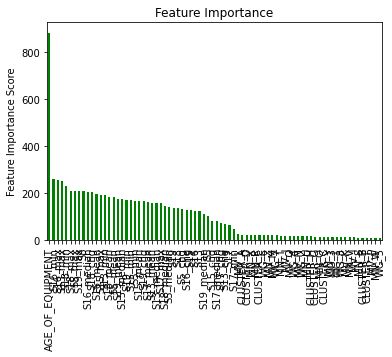

In [81]:
evaluate_model(xgb0, independent, dependent,features) 

Bem, o modelo é perfeito! Para podermos ir para casa e comemorar?


Ummm, ..., não tão rápido. Vamos ver como o modelo se comporta nos dados de treinamento não balanceados originais e nos dados de teste de retenção.

### 7.0 Avaliando o Modelo <a id="score"></a>

O elemento mais confuso dos problemas de PM é construir uma avaliação de modelo realista. Devido ao tempo e ao pequeno número de falhas, entender como o modelo funcionará uma vez implantado na produção é um desafio.

Existem métricas padrão para avaliar modelos como precisão, AUC e uma matriz de confusão. Nas seções abaixo, mostrarei como, dadas as transformações que usamos para construir nosso modelo e a complexidade do problema, essas métricas não nos dão uma visão realista do desempenho do modelo quando implantado em produção. Essas métricas padrão são úteis, mas não são suficientes.


#### 7.1 Avalie o modelo usando uma AUC e métricas de precisão.<a id="7.1"></a>

Já estabelecemos que o modelo prevê os dados de treinamento balanceados com 100% de precisão. Nesta seção, avaliaremos a precisão do modelo usando dados de treinamento e teste desbalanceados. A primeira etapa é dividir o quadro de dados original em dois — um quadro de dados para teste e um segundo para treinamento.

In [82]:

df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

Agora, vamos avaliar os dados de treinamento desbalanceados.

In [83]:


df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 1
AUC Score (Train): 1.000000


Continua perfeito!

Ok, não fique muito animado. Vamos dar uma olhada no conjunto de dados de teste de retenção. Vejamos o conjunto de dados de teste com um ponto de corte de 0,50.

In [84]:
df_testing['P_FAIL']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_FAIL'] = np.where(((df_testing.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FAILURE_TARGET'].values, df_testing['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_testing['FAILURE_TARGET'], df_testing['P_FAIL']))

Accuracy : 0.9537
AUC Score (Train): 0.530242


Antes de prosseguirmos, vamos dar um passo para trás e considerar o que fizemos. Nosso modelo valida com uma precisão de 0,9537.

Isso é bom ou ruim?

Neste ponto, eu honestamente não tenho idéia. O que isso diz sobre o desempenho desse modelo na produção? Quanto esse modelo melhorará as operações em relação ao "Business as Usual"?

Não podemos responder às perguntas acima com uma métrica de precisão. Não é possível. Para entender completamente como um modelo de PM funcionará, você deve colocá-lo no contexto de sua implantação. 

#### 7.2 Avalie o modelo usando uma matriz de confusão simples.<a id="7.2"></a>

Estabelecemos que o modelo se ajusta perfeitamente aos dados de treinamento, portanto, não perderemos tempo avaliando os dados de treinamento.

Vamos dar uma olhada nos dados de teste. Primeiro, faremos uma tabela cruzada da falha prevista com a variável de falha original, 'EQUIPMENT_FAILURE. Observe que esta é a variável de falha inicial. Aquela com apenas 421 valores. O outro lado da matriz de confusão é a variável binária prevista "Y_FAIL". Lembre-se, usamos um ponto de corte de 0,50 para definir essa variável.

In [85]:

print(pd.crosstab(df_testing.Y_FAIL, df_testing.EQUIPMENT_FAILURE, dropna=False))

EQUIPMENT_FAILURE       0    1
Y_FAIL                        
0                  107793  138
1                     977   11


A variável 'EQUIPMENT_FAILURE' identifica uma falha no dia em que ela ocorre. Digamos que a falha ocorra na sexta-feira e tenhamos sinais de falha na segunda, terça, quarta e quinta-feira, mas não na sexta-feira. Eu diria que a falha na sexta-feira é um verdadeiro positivo, dado que houve quatro sinais de falha nos dias que antecederam a falha. No entanto, a matriz de confusão acima conta segunda, terça, quarta e quinta-feira como falsos positivos e sexta-feira como falso negativo. Esta tabela cruzada por si só não nos dá uma visão realista de como o modelo será executado na produção.

Agora, vamos criar uma matriz de confusão usando 'FAILURE_TARGET.' Essa variável é a variável binária prevista em que os 28 dias que antecederam uma falha são sinalizados como falhas.

In [86]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.FAILURE_TARGET, dropna=False))

FAILURE_TARGET       0     1
Y_FAIL                      
0               103828  4103
1                  940    48


Com 'FAILURE_TARGET', temos 48 verdadeiros positivos, 4.103 falsos negativos, 940 falsos positivos e 103.328 verdadeiros negativos.

Isto funciona?

Não mesmo, hein? Pense nisso.

Cada falha é representada 28 vezes diferentes. Se uma máquina falhar na sexta-feira, 28, os vinte e sete dias anteriores do mês também serão sinalizados como falha. Isso claramente não vai funcionar, não é?

O exemplo acima claramente não reflete o que podemos esperar quando colocamos este modelo em produção. Para obter uma avaliação realista do modelo, devemos ter definições práticas de falsos positivos, falsos negativos, verdadeiros negativos e falsos negativos.

#### 7.3 Usando heurísticas para definir um falso positivo, um verdadeiro positivo, um falso negativo e um verdadeiro negativo.<a id="7.3"></a>

Primeiro, precisamos definir alguns parâmetros para avaliar com precisão nosso modelo de aprendizado de máquina. Eu costumo ajustar esses parâmetros com os conjuntos de dados de teste e treinamento e, em seguida, confirmo a precisão com o conjunto de dados de validação.

O primeiro parâmetro é a janela de previsão.

A janela de previsão é o período de tempo que um sinal de falha projeta no futuro.

Por exemplo, se houver um sinal de falha em 1º de junho, quanto tempo dura esse sinal?

Isso significa que a máquina vai quebrar no próximo segundo, minuto, hora, dia ou mês?

Observe que o comprimento da janela de previsão depende do contexto do problema. Se uma máquina falhar em 10 anos, a janela de previsão será relativamente longa, talvez até seis ou nove meses. Se uma máquina falhar em 1 dia, a janela de previsão será muito menor, talvez uma hora ou alguns minutos. O comprimento da janela de previsão deve ser útil para o problema. Por exemplo, uma janela de previsão de vinte e oito dias para uma máquina que funciona até a falha em trinta dias é de pouco valor.

Em nosso caso de uso atual, a máquina falha em quatro a seis anos, portanto, uma janela de previsão de noventa dias é razoável.

Também precisamos definir um valor de corte. Neste primeiro exemplo, usaremos um valor de corte de 0,50. O valor de corte determina se uma previsão é uma falha ou uma não falha. No exemplo atual, se a probabilidade de falha for menor que 0,5, trata-se de uma não falha prevista. Se a probabilidade de falha for maior que 0,5, é uma falha esperada.

In [87]:
forecast_window=90
cutoff=0.50


Crie uma probabilidade de falha para o conjunto de dados df_train_test. Observe que isso tem os dados de treinamento desbalanceados e os dados de teste desbalanceados. Uma vez que a probabilidade é definida, crie uma variável binária "Fail/No Fail" usando o valor de corte.

In [88]:
df=df_train_test

In [89]:
df['P_FAIL']= xgb0.predict_proba(df[features])[:,1];
df['Y_FAIL'] = np.where(((df.P_FAIL <= cutoff)), 0, 1)

Para avaliar efetivamente o modelo, devemos fazer três coisas. Primeiro, precisamos remover os sinais de falha redundantes. Ou seja, garanta que haja pelo menos 90 dias (a janela de previsão) entre cada sinal de falha nos dados. Dois, devemos garantir que os sinais de falha de uma máquina específica estejam alinhados com as falhas da mesma máquina. Terceiro, devemos entender o tempo entre os sinais e as falhas.

Observe que há muitas maneiras de fazer o que estou fazendo nas próximas etapas. É um processamento de dados simples. Não estou dizendo que este é o melhor caminho. Estou dizendo que funciona.

##### 7.31 Elimine sinais de falha redundantes<a id="7.31"></a>

Com base no contexto, pode haver apenas uma falha a cada 90 dias. Se ocorrerem vários sinais de falha em uma janela de noventa dias, esses sinais serão agregados e associados ao primeiro sinal.

Por exemplo, suponha que você tenha um sinal na segunda, terça, quarta e quinta-feira. Aqui, temos um único sinal de falha medido em quatro dias, não quatro sinais diferentes medidos em quatro dias diferentes. A última situação realmente não faz sentido. O problema de terça, quarta e quinta-feira não é independente do de segunda-feira. Os quatro estão conectados. Eles têm que ser e mesmo que não sejam, você deve ter verificado e reparado a máquina após o primeiro sinal.

Diante disso, para obter uma avaliação precisa do modelo, devemos consolidar os quatro sinais e associá-los ao primeiro dia da série de sinais (segunda-feira). Em outras palavras, os sinais de terça, quarta e quinta-feira são redundantes e estão sujeitos a remoção.
Novamente, um sinal de falha é bom por 90 dias (janela de previsão), portanto, um sinal que ocorre dentro da janela de 90 dias de um sinal anterior não é, por definição, NÃO um sinal separado de falha.

Vamos dar um passo para trás e olhar para isso pragmaticamente. Se você receber um sinal de falha hoje, agirá e verificará a máquina imediatamente, certo? Não é todo o ponto aqui? Só temos sinais consecutivos nos dados históricos porque o modelo ainda não existe. Em uma situação do mundo real, os sinais de falha sucessivos não devem ocorrer. Um sinal solicitará que a empresa verifique a máquina. Nesse ponto, o sinal se torna um falso positivo ou um verdadeiro positivo, fim da história.


Classifique os dados por id e data.

In [90]:

xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])

Crie uma lista exclusiva de máquinas

In [91]:

aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape

(295, 1)

Rotule cada máquina com um número sequencial. Precisamos que o id seja sequencial para uso em uma etapa posterior.

In [92]:

pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

,SCOOBYDOO,ID
0,1,100001
1,2,100002
2,3,100014
3,4,100017
4,5,100018


Pegue o número máximo de máquinas. Usaremos isso em um loop em uma etapa posterior.

In [93]:


column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

296

Anexe o número sequencial ao arquivo principal. Agora cada máquina um id sequencial.

In [94]:

xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,WG_2,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8,P_FAIL,Y_FAIL,SCOOBYDOO
0,0,100001,2014-12-02,G,O,Y,1,11.088,145.223448,39.34,...,0,0,0,0,0,0,0,0.000067,0,1
1,1,100001,2016-03-29,G,O,Y,1,18.960,0.000000,38.87,...,0,0,0,0,0,0,0,0.000131,0,1
2,2,100001,2016-03-30,G,O,Y,1,29.040,0.000000,37.36,...,0,0,0,0,0,0,0,0.000429,0,1
3,3,100001,2016-03-31,G,O,Y,1,18.000,0.000000,38.81,...,0,0,0,0,0,0,0,0.000127,0,1
4,4,100001,2016-04-01,G,O,Y,1,26.160,0.000000,39.47,...,0,0,0,0,0,0,0,0.000001,0,1


Classifique os dados por ID e Data e redefina o índice do dataframe para que corresponda à classificação.

In [95]:

xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

As próximas etapas atribuem um novo indicador de falha que incorpora a janela de previsão. Observe que esse cálculo ocorre no nível da máquina. Isso mantém um sinal de uma máquina afetando outra máquina.

  Esse loop demora um pouco para ser executado.
 
  A saída é um novo indicador de falha chamado "Y_FAILZ". Este sinal de falha incorpora a janela de previsão e não ocorrerá mais de uma vez a cada 90 dias.

In [96]:
#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape



#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        
xx=df_fred

# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)


df=xx

##### 7.32 Identifique o ID da máquina para cada sinal. Identifique a data do sinal de falha.<a id="7.32"></a>

Para determinar se um sinal é preciso, precisamos coletar mais duas informações.

A primeira é a data do sinal de falha. Precisaremos comparar a data da falha com a data do sinal de falha para garantir que o sinal esteja dentro da janela de previsão.

Lembre-se de que estamos trabalhando com um conjunto de dados em painel. Temos várias máquinas medidas ao longo do tempo. Temos que alinhar os sinais e falhas por máquina. Em outras palavras, não queremos um sinal da máquina 1 associado a uma falha na máquina 2. Os sinais da máquina 1 destinam-se a prever falhas na máquina 1, não na máquina 2. Se tivermos um ID de máquina para cada sinal de falha , podemos garantir que ele esteja alinhado com o ID da máquina da falha.


Classifique os dados por id e data.

In [97]:

xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


Crie o ID do sinal com a função cumsum.

In [98]:

xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()



Agora vamos puxar os registros com um sinal para um quadro de dados diferente.

Aqui vamos criar um novo campo que identifica a data de cada sinal (SIGNAL_DATE).

Além disso, identificaremos o ID da máquina associado a cada sinal (ID_OF_SIGNAL)



In [99]:
df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})

Temos um total de 282 sinais. Agora cada um tem um id único e um dado associado ao sinal.

In [100]:
df_signal_date.shape

(282, 3)

Anexe ID_OF_SIGNAL e SIGNAL_DATE à base do Dataframe original no SIGNAL_ID.

In [101]:
xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer') 

In [102]:
df=xx.copy()

Simplifique mantendo apenas os campos que precisamos daqui para frente.

In [103]:
df=df[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]

Crie um campo chamado "Aviso" que indica o tempo entre o sinal e a falha.

In [104]:

df['C'] = df['FAILURE_DATE'] - df['SIGNAL_DATE'].copy()
df['WARNING'] = df['C'] / np.timedelta64(1, 'D').copy()



In [105]:
df.head()

,DATE,ID,EQUIPMENT_FAILURE,FAILURE_TARGET,FAILURE_DATE,P_FAIL,Y_FAILZ,SIGNAL_ID,SIGNAL_DATE,ID_OF_SIGNAL,MODELING_GROUP,C,WARNING
0,2014-12-02,100001,0,0,2015-04-24,6.742236e-05,0,0,NaT,NaN,TESTING,NaT,NaN
1,2014-12-03,100001,0,0,2015-04-24,1.272629e-07,0,0,NaT,NaN,TESTING,NaT,NaN
2,2014-12-04,100001,0,0,2015-04-24,3.604138e-06,0,0,NaT,NaN,TESTING,NaT,NaN
3,2014-12-05,100001,0,0,2015-04-24,6.413556e-04,0,0,NaT,NaN,TESTING,NaT,NaN
4,2014-12-06,100001,0,0,2015-04-24,4.513847e-05,0,0,NaT,NaN,TESTING,NaT,NaN


##### 7.33 Crie uma matriz de confusão realista.<a id="7.33"></a>

Finalmente, temos informações suficientes para definir um falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo.



Um verdadeiro positivo ocorre se e somente se a máquina falhar e houver um sinal nos últimos 90 dias. Além disso, temos que garantir que o ID do sinal pertença à máquina (ID). Observe que isso proíbe que um sinal de outra máquina seja aplicado à máquina em questão.

Um falso negativo ocorre se e somente se a máquina falhar e não for um verdadeiro positivo.

Um Falso Positivo ocorre se houver um sinal de falha e uma falha não ocorrer nos próximos 90 dias. Além disso, se ocorrer um sinal após a falha, trata-se de um falso positivo. Também devemos garantir que o ID do sinal pertença ao ID da máquina.

Se uma observação não for um Falso Positivo, um Falso Negativo ou um Verdadeiro Positivo, é um Verdadeiro Negativo.


In [106]:
# define a true positive
df['TRUE_POSITIVE'] = np.where(((df.EQUIPMENT_FAILURE == 1) & (df.WARNING<=forecast_window) &(df.WARNING>=0) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)

In [107]:
# define a false negative
df['FALSE_NEGATIVE'] = np.where((df.TRUE_POSITIVE==0) & (df.EQUIPMENT_FAILURE==1), 1, 0)

In [108]:
# define a false positive
df['BAD_S']=np.where((df.WARNING<0) | (df.WARNING>=forecast_window | df.WARNING.isnull().values.any()), 1, 0)
#note that the 

df['FALSE_POSITIVE'] = np.where(((df.Y_FAILZ == 1) & (df.BAD_S==1) & (df.ID_OF_SIGNAL==xx.ID)), 1, 0)

In [109]:
df['bootie']=1

In [110]:
df['CATEGORY']=np.where((df.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((df.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((df.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

Antes de avaliarmos a matriz de confusão, vamos examinar uma máquina para confirmar que nossa lógica está correta.

In [111]:
pd.options.display.max_rows = 1000
dd=df[df['ID']==100002]
dd.head(1000)

,DATE,ID,EQUIPMENT_FAILURE,FAILURE_TARGET,FAILURE_DATE,P_FAIL,Y_FAILZ,SIGNAL_ID,SIGNAL_DATE,ID_OF_SIGNAL,MODELING_GROUP,C,WARNING,TRUE_POSITIVE,FALSE_NEGATIVE,BAD_S,FALSE_POSITIVE,bootie,CATEGORY
731,2014-12-02,100002,0,0,2015-10-27,2.163839e-07,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
732,2014-12-03,100002,0,0,2015-10-27,9.729978e-07,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
733,2014-12-04,100002,0,0,2015-10-27,3.035358e-06,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
734,2014-12-05,100002,0,0,2015-10-27,1.146315e-05,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
735,2014-12-06,100002,0,0,2015-10-27,3.133813e-06,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
736,2014-12-07,100002,0,0,2015-10-27,3.506438e-06,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
737,2014-12-08,100002,0,0,2015-10-27,5.355490e-07,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
738,2014-12-09,100002,0,0,2015-10-27,4.773490e-06,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
739,2014-12-10,100002,0,0,2015-10-27,1.429559e-07,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE
740,2014-12-11,100002,0,0,2015-10-27,1.671111e-06,0,0,NaT,NaN,TRAINING,NaT,NaN,0,0,0,0,1,TRUE_NEGATIVE


Ao examinar os dados acima, você pode ver o sinal de falha ocorrido em 30/09/2015. A falha associada a esta máquina é 27/10/2015. O tempo entre o sinal é de 27 dias, dentro da janela de 90 dias. Portanto, o sinal é um Verdadeiro Positivo (linha 1060)

In [112]:
table = pd.pivot_table(df, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                 126.0          113.0      108657.0          23.0
TRAINING                  NaN            NaN      106580.0         146.0

Assim, no conjunto de dados de teste, temos 126 falsos negativos, 113 falsos positivos, 108.657 verdadeiros negativos e 23 verdadeiros positivos. Essas métricas incorporam a janela de falha e devem fornecer uma visão mais realista de como o modelo funcionará na produção.

Isso é bom? Sinceramente ainda não faço ideia. Para entender completamente se o modelo é bom, devemos examiná-lo no contexto do problema. Precisamos avaliar o modelo em relação aos custos atuais e quanto um modelo reduzirá esses custos.

#### 7.34 Incorporando a Economia do Problema.<a id="7.34"></a>

Usando os custos associados a essas métricas, o que os resultados significam do ponto de vista econômico?


Lembre-se disso?


In [113]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")



Um falso positivo é “Manutenção Desnecessária”. Um verdadeiro positivo é uma “manutenção oportuna e apropriada”. Um falso negativo é “A máquina funciona até a falha”.

Um falso positivo custa US$ 1.500.

Um falso negativo custa US$ 30.000.

Um verdadeiro positivo custa US$ 7.500.

Um verdadeiro negativo não tem custo porque nenhuma ação é tomada.

Agora podemos calcular o custo total.

In [114]:
df['TOTAL_COST']=df.FALSE_NEGATIVE*30000+df.FALSE_POSITIVE*1500+df.TRUE_POSITIVE*7500

Agregar os custos por grupo de modelagem.

In [115]:
table = pd.pivot_table(df, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)
table

,TOTAL_COST
MODELING_GROUP,
TESTING,4122000
TRAINING,1095000


Calcule o número de máquinas em cada grupo de modelagem.

In [116]:
wells=df[['ID','MODELING_GROUP']]
wells=wells.drop_duplicates(subset='ID')
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})
wells


,WELLS
MODELING_GROUP,
TESTING,149
TRAINING,146


Mescle os custos totais e o total de máquinas em um quadro de dados.

In [117]:
tc = df.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)

In [118]:
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')

Calcule o custo médio por máquina.


In [119]:
ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST
ac

,TOTAL_COST,WELLS,AVERAGE_COST,LIFT
MODELING_GROUP,,,,
TESTING,4122000,149,27664.42953,283.57047
TRAINING,1095000,146,7500.00000,20448.00000


Isso é bom? Na verdade, não. Ao usar a manutenção preditiva, reduzimos o custo de operação de cada máquina em 283 dólares. Multiplicado por 419 máquinas, isso representa uma economia total de 118.577 dólares.

Acho que podemos fazer melhor, no entanto. Vamos ajustar nossos parâmetros ..

#### 7.4 Ajustando a solução.<a id="7.4"></a>

Primeiro, vamos definir a janela de previsão e alterar o corte de 0,50 para 0,015. Se a probabilidade for menor que 0,015, esperamos uma não falha. Se a probabilidade for maior que 0,015, esperamos uma falha. A janela de previsão não muda.


In [120]:
forecast_window=90
cutoff=0.02

Agora, limpe os dados para que ocorra apenas um sinal de falha a cada 90 dias. Associe uma máquina a cada sinal e encontre a data de cada sinal.

In [121]:
df=df_train_test

In [122]:
df['P_FAIL']= xgb0.predict_proba(df[features])[:,1];
df['Y_FAIL'] = np.where(((df.P_FAIL <= cutoff)), 0, 1)
#sort the data by id and date.
xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])
#create a unique list of machines
aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]


#label each machine with a sequential number
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

#grab the max number of machines +1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

#append sequential number to main file.  Now each machine has a sequencial id.
xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

#sort data
xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape


#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        
        
xx=df_fred

# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)


#sort the data by id and date.

xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()


df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})



xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer') 


xx=xx[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]



xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')




df=xx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Use Heurística para definir falsos positivos, falsos negativos, verdadeiros positivos e verdadeiros negativos.

In [123]:
# define a true positive
df['TRUE_POSITIVE'] = np.where(((df.EQUIPMENT_FAILURE == 1) & (df.WARNING<=forecast_window) &(df.WARNING>=0) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)


# define a false negative
df['FALSE_NEGATIVE'] = np.where((df.TRUE_POSITIVE==0) & (df.EQUIPMENT_FAILURE==1), 1, 0)

# define a false positive
df['BAD_S']=np.where((df.WARNING<0) | (df.WARNING>=forecast_window), 1, 0)

df['FALSE_POSITIVE'] = np.where(((df.Y_FAILZ == 1) & (df.BAD_S==1) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)

df['bootie']=1

df['CATEGORY']=np.where((df.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((df.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((df.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Agora podemos examinar uma tabulação cruzada.

In [124]:
table = pd.pivot_table(df, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                    99            262        108508            50
TRAINING                    6             42        106538           140

Novamente, não tenho ideia se esses resultados são bons. Para avaliar a eficácia do modelo, precisamos incorporar a economia.

In [125]:

#Now we can calculate the total cost.
df['TOTAL_COST']=df.FALSE_NEGATIVE*30000+df.FALSE_POSITIVE*1500+df.TRUE_POSITIVE*7500
#Aggregate the costs by modeling group.
table = pd.pivot_table(df, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)

#Calculate the number of machines in each modeling group.
wells=df[['ID','MODELING_GROUP']]
wells=wells.drop_duplicates(subset='ID')
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})

tc = df.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)
#Merge the total costs and total machines into one data frame.
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')
#Calculate the average cost per machine.

ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST
ac

,TOTAL_COST,WELLS,AVERAGE_COST,LIFT
MODELING_GROUP,,,,
TESTING,3738000,149,25087.248322,2860.751678
TRAINING,1293000,146,8856.164384,19091.835616


OK. Essas métricas parecem muito melhores, mas não vamos ficar muito animados até confirmarmos os resultados no conjunto de dados de validação.

#### 7.5 Validando a solução.<a id="7.3"></a>

In [126]:
df=df_total

In [127]:
df['P_FAIL']= xgb0.predict_proba(df[features])[:,1];
df['Y_FAIL'] = np.where(((df.P_FAIL <= cutoff)), 0, 1)
#sort the data by id and date.
xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])
#create a unique list of machines
aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]


#label each machine with a sequential number
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

#grab the max number of machines +1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

#append sequential number to main file.  Now each machine has a sequencial id.
xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

#sort data
xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape


#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        
        
xx=df_fred

# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)


#sort the data by id and date.

xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()


df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})



xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer') 


xx=xx[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]



xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')




df=xx






# define a true positive
df['TRUE_POSITIVE'] = np.where(((df.EQUIPMENT_FAILURE == 1) & (df.WARNING<=forecast_window) &(df.WARNING>=0) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)


# define a false negative
df['FALSE_NEGATIVE'] = np.where((df.TRUE_POSITIVE==0) & (df.EQUIPMENT_FAILURE==1), 1, 0)

# define a false positive
df['BAD_S']=np.where((df.WARNING<0) | (df.WARNING>=forecast_window), 1, 0)

df['FALSE_POSITIVE'] = np.where(((df.Y_FAILZ == 1) & (df.BAD_S==1) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)

df['bootie']=1

df['CATEGORY']=np.where((df.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((df.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((df.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))




#Now we can calculate the total cost.
df['TOTAL_COST']=df.FALSE_NEGATIVE*30000+df.FALSE_POSITIVE*1500+df.TRUE_POSITIVE*7500
#Aggregate the costs by modeling group.
table = pd.pivot_table(df, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)

#Calculate the number of machines in each modeling group.
wells=df[['ID','MODELING_GROUP']]
wells=wells.drop_duplicates(subset='ID')
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})

tc = df.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)
#Merge the total costs and total machines into one data frame.
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')
#Calculate the average cost per machine.

ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST
ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,TOTAL_COST,WELLS,AVERAGE_COST,LIFT
MODELING_GROUP,,,,
TESTING,3738000,149,25087.248322,2860.751678
TRAINING,1293000,146,8856.164384,19091.835616
VALIDATION,3072000,126,24380.952381,3567.047619


###  8.0 Conclusões <a id="conc"></a>

## Agora temos tudo o que precisamos para examinar a eficácia do modelo.

### Atualmente, a manutenção custa à empresa cerca de 27.948 dólares por máquina no conjunto de dados atual. No conjunto de dados de validação, o custo por máquina é 24.380. Uma solução de manutenção preditiva reduzirá o custo por máquina em cerca de 3.567 dólares por máquina no conjunto de validação. Para sermos conservadores, provavelmente devemos pegar o menor dos conjuntos de dados de teste e validação, então vamos usar 2.860 como um aumento na métrica BAU. O aumento multiplicado por 421 máquinas equivale a 1,204 milhão de economia ou cerca de 10% de redução nas despesas totais.

---





Autor





**Renan Garcia**, Msc. Modeling and Optimization